<a href="https://colab.research.google.com/github/UmarBalak/AdaptFL/blob/main/AdaptFL_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import h5py
import torch.nn.functional as F
from torchvision import transforms

class CARLADataset(Dataset):
    def __init__(self, directory, transform=None, one_hot=True, combined_control=False, cache=False):
        """
        Args:
            directory (string): Directory with all the hdf5 files containing the episode data.
            transform (callable, optional): Optional transform to be applied on a sample.
            one_hot (bool): Whether to apply one-hot encoding to high-level commands (hlc) and lights.
            combined_control (bool): Whether to combine throttle and brake control into a single value.
            cache (bool): Whether to cache preprocessed batches.
        """
        self.file_paths = glob.glob(os.path.join(directory, "*.hdf5"))
        if len(self.file_paths) == 0:
            raise FileNotFoundError(f"No .hdf5 files found in the directory {directory}. Please check the path.")

        print(f"Found {len(self.file_paths)} hdf5 files.")

        self.file_paths.sort()  # Ensuring data is processed in order
        self.transform = transform
        self.cache = cache

        self.lengths = []
        self.total_length = 0
        self.files = []
        for file_path in self.file_paths:
            try:
                file = h5py.File(file_path, 'r')
                self.files.append(file)
                length = file['frame'].shape[0]
                self.lengths.append(length)
                self.total_length += length
                print(f"Loaded file: {file_path}, Length: {length}")
            except OSError as e:
                print(f"Error opening file {file_path}: {e}")
                continue

        self.one_hot = one_hot
        self.combined_control = combined_control

        # Optional cache for preprocessed data
        self.cache_data = {} if cache else None

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        print(f"Fetching data for index {idx}")
        if self.cache and idx in self.cache_data:
            return self.cache_data[idx]

        if torch.is_tensor(idx):
            idx = idx.tolist()

        # find the file that contains the data for the given index
        file_idx = 0
        while idx >= self.lengths[file_idx]:
            idx -= self.lengths[file_idx]
            file_idx += 1

        print(f"Using file index {file_idx} for item index {idx}")
        file = self.files[file_idx]

        # Create a dictionary for the data sample
        hlc = torch.tensor(file['hlc'][idx][0], dtype=torch.long)
        light = torch.tensor(file['light'][idx][0], dtype=torch.long)
        if self.one_hot:
            hlc = F.one_hot(hlc.to(torch.int64), num_classes=4)
            light = F.one_hot(light.to(torch.int64), num_classes=4)

        sample = {
            'hlc': hlc,
            'light': light,
            'controls': file['controls'][idx],
            'measurements': torch.tensor(file['measurements'][idx][0], dtype=torch.float32),
            'rgb': torch.tensor(file['rgb'][idx], dtype=torch.float32).permute(2, 0, 1),
            'segmentation': torch.tensor(file['segmentation'][idx], dtype=torch.float32).permute(2, 0, 1)
        }

        # Apply transforms if provided
        if self.transform:
            sample = self.transform(sample)

        # Normalize images and stack RGB with segmentation
        rgb = sample['rgb'] / 255.0
        segmentation = sample['segmentation'] / 255.0
        img = torch.cat((rgb, segmentation), dim=0)

        # Normalize and clip speed measurement
        sample['measurements'] = torch.clamp(sample['measurements'] / 40.0, 0, 1.0).to(torch.float32)

        # Convert steer from [-1, 1] to [0, 1]
        controls = sample['controls']
        if not self.combined_control:
            controls = torch.tensor([controls[0], (controls[1] + 1.0) / 2.0, controls[2]], dtype=torch.float32)
        else:  # combine throttle and brake
            controls = torch.tensor([(controls[0] - controls[2] + 1.0) / 2.0, (controls[1] + 1.0) / 2.0], dtype=torch.float32)

        result = img, sample['measurements'], sample['hlc'], sample['light'], controls

        # Cache preprocessed data if enabled
        if self.cache:
            self.cache_data[idx] = result

        return result

    def __del__(self):
        self.close()

    def close(self):
        for file in self.files:
            file.close()

if __name__ == '__main__':
    data_dir = "/content/"  # Update this to your actual data directory

    # Debug: Check if files are being loaded
    file_paths = glob.glob(os.path.join(data_dir, "*.hdf5"))
    print(f"Found {len(file_paths)} hdf5 files.")

    dataset = CARLADataset(data_dir, cache=False)

    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    num_batches = len(dataloader)
    print(f"Total number of batches: {num_batches}")

    for i, (img_batch, speed_batch, hlc_batch, light_batch, controls_batch) in enumerate(dataloader):
        if i >= num_batches:
            break
        print(f"Batch {i + 1}:")
        print(f"Image batch shape: {img_batch.shape}")


Found 1 hdf5 files.
Found 1 hdf5 files.
Loaded file: /content/episode_0.hdf5, Length: 1419
Total number of batches: 45


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fetching data for index 0Fetching data for index 32

Using file index 0 for item index 32Using file index 0 for item index 0Fetching data for index 64


Using file index 0 for item index 64
Fetching data for index 96
Using file index 0 for item index 96
Fetching data for index 33Fetching data for index 65
Fetching data for index 97
Fetching data for index 1Using file index 0 for item index 65


Using file index 0 for item index 33Using file index 0 for item index 97
Using file index 0 for item index 1

Fetching data for index 34Fetching data for index 66

Fetching data for index 98
Using file index 0 for item index 34
Using file index 0 for item index 66Using file index 0 for item index 98

Fetching data for index 2
Using file index 0 for item index 2
Fetching data for index 35
Using file index 0 for item index 35Fetching data for index 99
Fetching data for index 67

Using file index 0 for item index 99Fetching data for index 3Using file index 0 for item index 67


Fetching data for in

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import h5py
import torch.nn.functional as F

class CARLADataset(Dataset):
    def __init__(self, directory, transform=None, one_hot=True, combined_control=False):
        """
        Args:
            directory (string): Directory with all the hdf5 files containing the episode data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file_paths = glob.glob(os.path.join(directory, "*.hdf5"))
        self.file_paths.sort()  # Ensuring data is processed in order
        self.transform = transform

        self.lengths = []
        self.total_length = 0
        self.files = []
        for file_path in self.file_paths:
            file = h5py.File(file_path, 'r')
            self.files.append(file)
            length = file['frame'].shape[0]
            self.lengths.append(length)
            self.total_length += length

        self.one_hot = one_hot
        self.combined_control = combined_control

    def __len__(self):
        return self.total_length


    # one hot encoding for high-level ommand
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # find the file that contains the data for the given index
        file_idx = 0
        while idx >= self.lengths[file_idx]:
            idx -= self.lengths[file_idx]
            file_idx += 1

        file = self.files[file_idx]

        # create a dictionary for the data sample
        hlc = torch.tensor(file['hlc'][idx][0], dtype=torch.long)
        light = torch.tensor(file['light'][idx][0], dtype=torch.long)
        if self.one_hot:
            hlc = F.one_hot(hlc.to(torch.int64), num_classes=4)
            light = F.one_hot(light.to(torch.int64), num_classes=4)
        sample = {
            'hlc': hlc,
            'light': light,
            'controls': file['controls'][idx],
            'measurements': torch.tensor(file['measurements'][idx][0], dtype=torch.float32),
            'rgb': torch.tensor(file['rgb'][idx], dtype=torch.float32).permute(2, 0, 1),
            'segmentation': torch.tensor(file['segmentation'][idx], dtype=torch.float32).permute(2, 0, 1)
        }

        if self.transform:
            sample = self.transform(sample)

        # normlize the images and stack RGB with segmentation
        rgb = sample['rgb'] / 255.0
        segmentation = sample['segmentation'] / 255.0
        img = torch.cat((rgb, segmentation), dim=0)

        # normalize and clip speed measurement
        sample['measurements'] = torch.clamp(sample['measurements'] / 40.0, 0, 1.0).to(torch.float32)

        # convert steer from [-1, 1] to [0, 1]
        controls = sample['controls']
        if not self.combined_control:
            controls = torch.tensor([controls[0], (controls[1]+ 1.0) / 2.0, controls[2]], dtype=torch.float32)
        else: # combine throttle and brake
            controls = torch.tensor([(controls[0] - controls[2] + 1.0) / 2.0, (controls[1]+ 1.0) / 2.0], dtype=torch.float32)

        return img, sample['measurements'], sample['hlc'], sample['light'], controls

    def close(self):
        for file in self.files:
            file.close()

if __name__ == '__main__':
    # Set the directory where your .pkl files are
    data_dir = "/content/"

    # Create the dataset
    dataset = CARLADataset(data_dir)
    print(len(dataset))
    # Create the dataloader
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) #set shuffle=False to take advantage of caching

    # Get a batch of data
    img_batch, speed_batch, hlc_batch, light_batch, controls_batch = next(iter(dataloader)) # unpack the 5 returned values

    # Check the shapes of the data
    print("Image batch shape:", img_batch.shape)
    print("Speed batch shape:", speed_batch.shape)
    print("Controls batch shape:", controls_batch.shape)

    # Check the range of values in the image batch (should be [0, 1])
    print("Image batch min:", img_batch.min().item())
    print("Image batch max:", img_batch.max().item())

    # Check the range of values in the speed batch (should be [0, 1])
    print("Speed batch min:", speed_batch.min().item())
    print("Speed batch max:", speed_batch.max().item())

    # Check the range of values in the speed batch (should be [0, 1])
    print("HLC batch min:",hlc_batch.min().item())
    print("HLC batch max:", hlc_batch.max().item())

    # Check the range of values in the controls batch
    print("Controls batch min:", controls_batch.min().item())
    print("Controls batch max:", controls_batch.max().item())

1419
Image batch shape: torch.Size([32, 6, 200, 288])
Speed batch shape: torch.Size([32])
Controls batch shape: torch.Size([32, 3])
Image batch min: 0.0
Image batch max: 1.0
Speed batch min: 0.03223826736211777
Speed batch max: 0.8612362146377563
HLC batch min: 0
HLC batch max: 1
Controls batch min: 0.0
Controls batch max: 0.8500000238418579


# From Scratch

## Step 1: Load the Data

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the HDF5 file
def load_episode_data(filepath):
    with h5py.File(filepath, 'r') as f:
        data = {
            'frame': f['frame'][:],
            'hlc': f['hlc'][:],
            'light': f['light'][:],
            'controls': f['controls'][:],  # throttle, steer, brake
            'measurements': f['measurements'][:],  # speed
            'rgb': f['rgb'][:],  # raw RGB image data
            'segmentation': f['segmentation'][:]  # segmentation masks
        }
    return data

# Load episode data
episode_data = load_episode_data('/content/episode_0.hdf5')


In [ ]:
len(episode_data)

7

## Step 2: Analyze the Data

### 2.1: Explore Dataset Fields

In [ ]:
def analyze_data(data):
    print("Number of frames:", len(data['frame']))
    print("HLC shape:", data['hlc'].shape)
    print("Controls shape (Throttle, Steer, Brake):", data['controls'].shape)
    print("Measurements (Speed):", data['measurements'].shape)
    print("RGB Image shape:", data['rgb'].shape)
    print("Segmentation Image shape:", data['segmentation'].shape)

    # Check unique high-level commands (HLC)
    unique_hlc = np.unique(data['hlc'])
    print("Unique high-level commands (HLC):", unique_hlc)

    # Check traffic light statuses
    unique_lights = np.unique(data['light'])
    print("Unique traffic light statuses:", unique_lights)

# Run analysis
analyze_data(episode_data)


Number of frames: 1419
HLC shape: (1419, 1)
Controls shape (Throttle, Steer, Brake): (1419, 3)
Measurements (Speed): (1419, 1)
RGB Image shape: (1419, 200, 288, 3)
Segmentation Image shape: (1419, 200, 288, 3)
Unique high-level commands (HLC): [0 1 2 3]
Unique traffic light statuses: [0 1 2]


### 2.2: Visualize the Data

Exception ignored in: <function CARLADataset.__del__ at 0x7ca6058d5510>
Traceback (most recent call last):
  File "<ipython-input-17-c6a121fe3209>", line 114, in __del__
  File "<ipython-input-17-c6a121fe3209>", line 117, in close
AttributeError: 'CARLADataset' object has no attribute 'files'


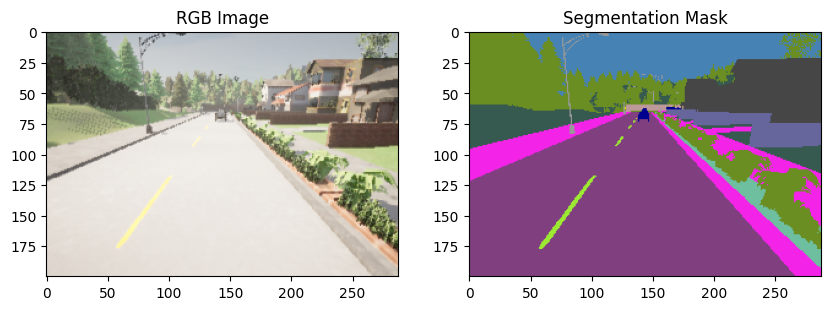

In [ ]:
def visualize_sample(data, frame_idx=0):
    # Select frame
    rgb_image = data['rgb'][frame_idx]
    seg_image = data['segmentation'][frame_idx]

    # Convert RGB to displayable image
    rgb_image = Image.fromarray(rgb_image.astype('uint8'))

    # Plot RGB and Segmentation side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Image')

    axs[1].imshow(seg_image)
    axs[1].set_title('Segmentation Mask')

    plt.show()

# Visualize sample frame
visualize_sample(episode_data, frame_idx=0)


## Step 3: Preprocessing

### 3.1: Normalize Control Values

In [ ]:
def normalize_controls(controls):
    # Normalize the control values to the range [0, 1] (if not already)
    controls[:, 0] = controls[:, 0] / np.max(controls[:, 0])  # throttle
    controls[:, 1] = (controls[:, 1] + 1) / 2  # steer [-1, 1] -> [0, 1]
    controls[:, 2] = controls[:, 2] / np.max(controls[:, 2])  # brake
    return controls

# Normalize control values
episode_data['controls'] = normalize_controls(episode_data['controls'])


### 3.2: Normalize Speed (Measurements)

In [ ]:
def normalize_speed(speed):
    max_speed = 100  # Assuming 100 km/h as max speed
    return speed / max_speed

# Normalize speed
episode_data['measurements'] = normalize_speed(episode_data['measurements'])


### 3.3: Resize Images

In [ ]:
from torchvision import transforms

def resize_images(images, size=(128, 128)):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    resized_images = np.array([transform(img) for img in images])
    return resized_images

# Resize RGB and Segmentation images
episode_data['rgb'] = resize_images(episode_data['rgb'])
episode_data['segmentation'] = resize_images(episode_data['segmentation'])


## Step 4: Batching and Dataloader Setup

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom PyTorch Dataset
class CARLADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['frame'])

    def __getitem__(self, idx):
        rgb = torch.tensor(self.data['rgb'][idx], dtype=torch.float32)
        segmentation = torch.tensor(self.data['segmentation'][idx], dtype=torch.float32)
        controls = torch.tensor(self.data['controls'][idx], dtype=torch.float32)
        speed = torch.tensor(self.data['measurements'][idx], dtype=torch.float32)
        hlc = torch.tensor(self.data['hlc'][idx], dtype=torch.int64)
        light = torch.tensor(self.data['light'][idx], dtype=torch.int64)

        return rgb, segmentation, controls, speed, hlc, light

# Create dataset and DataLoader
carla_dataset = CARLADataset(episode_data)
carla_dataloader = DataLoader(carla_dataset, batch_size=32, shuffle=True)
